# Download Dataset

In [1]:
#!pip install roboflow
#!pip install torch
#!pip install torchvision
#!pip install tensorboard

In [2]:
# Import the dataset
from roboflow import Roboflow
rf = Roboflow(api_key="dnZcw1fNasJT5SaFbDdG")
project = rf.workspace("vortexbuoytrainingset").project("buoy-detection-qzjg1")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


# Dataset Overview

In [3]:
from PIL import Image
import os
from collections import Counter

def check_image_dataset(directory_path, annotation_dir, target_dimensions=None):
    """
    Checks an image dataset for validity and optional dimension requirements,
    validates the corresponding annotation files in YOLO format, and counts
    occurrences of each label to detect potential imbalance.

    Args:
        directory_path (str): Path to the dataset directory containing images.
        annotation_dir (str): Path to the directory containing YOLO annotation files.
        target_dimensions (tuple): Optional. A tuple (width, height) to validate image dimensions.

    Returns:
        None
    """
    valid_images = 0
    invalid_images = 0
    label_count = 0
    missing_labels = 0
    label_frequencies = Counter()

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tif')):
                file_path = os.path.join(root, file)
                label_path = os.path.join(annotation_dir, os.path.splitext(file)[0] + '.txt')

                try:
                    # Open and validate image
                    with Image.open(file_path) as img:
                        if target_dimensions and img.size != target_dimensions:
                            print(f"   WARNING: Image dimensions {img.size} do not match target {target_dimensions}.")
                        img.verify()
                        valid_images += 1

                    # Validate label file
                    if os.path.exists(label_path):
                        with open(label_path, 'r') as label_file:
                            lines = label_file.readlines()
                            label_count += len(lines)

                            # Parse labels and update frequency count
                            for i, line in enumerate(lines):
                                parts = line.strip().split()
                                if len(parts) != 5:
                                    print(f"   ERROR: Invalid YOLO format in {label_path} on line {i + 1}: {line}")
                                else:
                                    label_class = parts[0]
                                    label_frequencies[label_class] += 1
                    else:
                        print(f"   WARNING: Missing label file for {file_path}")
                        missing_labels += 1

                except (IOError, SyntaxError) as e:
                    print(f"ERROR: {file_path} is invalid or corrupted. Error: {e}")
                    invalid_images += 1

    print("\nDataset Check Complete!")
    print(f" - Total valid images: {valid_images}")
    print(f" - Total invalid/corrupt images: {invalid_images}")
    print(f" - Total labels processed: {label_count}")
    print(f" - Missing label files: {missing_labels}")

    print("\nLabel Frequencies:")
    for label, count in label_frequencies.items():
        print(f" - Label {label}: {count} occurrences ({round(count/len(label_frequencies))}%)")

# Download Dataset

In [4]:
# Dataset image size 640x640
original_image_size = 640

# Train dataset
images_train_dir = "Buoy-Detection-1/train/images"
annotations_train_dir = "Buoy-Detection-1/train/labels"
check_image_dataset(images_train_dir, annotations_train_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 521
 - Total invalid/corrupt images: 0
 - Total labels processed: 521
 - Missing label files: 0

Label Frequencies:
 - Label 2: 130 occurrences (32%)
 - Label 0: 148 occurrences (37%)
 - Label 3: 132 occurrences (33%)
 - Label 1: 111 occurrences (28%)


In [5]:
# Test dataset
images_test_dir = "Buoy-Detection-1/test/images"
annotations_test_dir = "Buoy-Detection-1/test/labels"
check_image_dataset(images_test_dir, annotations_test_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 75
 - Total invalid/corrupt images: 0
 - Total labels processed: 75
 - Missing label files: 0

Label Frequencies:
 - Label 0: 21 occurrences (5%)
 - Label 3: 19 occurrences (5%)
 - Label 2: 19 occurrences (5%)
 - Label 1: 16 occurrences (4%)


In [6]:
# Validation dataset
images_valid_dir = "Buoy-Detection-1/valid/images"
annotations_valid_dir = "Buoy-Detection-1/valid/labels"
check_image_dataset(images_valid_dir, annotations_valid_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 148
 - Total invalid/corrupt images: 0
 - Total labels processed: 148
 - Missing label files: 0

Label Frequencies:
 - Label 0: 42 occurrences (10%)
 - Label 2: 37 occurrences (9%)
 - Label 1: 32 occurrences (8%)
 - Label 3: 37 occurrences (9%)


## Ploting some samples

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_sample_with_bboxes(image_dir, label_dir, class_names, num_samples=5):
    """
    Plots samples from the dataset with bounding boxes and class labels.

    Args:
        image_dir (str): Path to the directory containing images.
        label_dir (str): Path to the directory containing YOLO annotations (labels).
        class_names (list): List of class names corresponding to class IDs.
        num_samples (int): Number of samples to plot.

    Returns:
        None
    """
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if len(image_files) == 0:
        print("No images found in the specified directory.")
        return

    # Sample a few images
    sampled_images = image_files[:num_samples] if num_samples < len(image_files) else image_files

    for image_file in sampled_images:
        # File paths
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

        # Load image
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.imshow(img)
            ax.set_title(f"Image: {image_file}")

            # If label file exists, draw bounding boxes
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            print(f"Invalid label format in {label_path}. Skipping line: {line}")
                            continue
                        
                        # Parse YOLO annotation
                        class_id, x_center, y_center, width, height = map(float, parts)
                        class_name = class_names[int(class_id)] if int(class_id) < len(class_names) else f"Class {int(class_id)}"
                        
                        # Convert normalized YOLO bbox to pixel coordinates
                        img_width, img_height = img.size
                        x_center *= img_width
                        y_center *= img_height
                        width *= img_width
                        height *= img_height
                        
                        # Top-left corner
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        
                        # Draw rectangle
                        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
                        ax.add_patch(rect)
                        ax.text(x_min, y_min - 5, class_name, color='green', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

            plt.show()

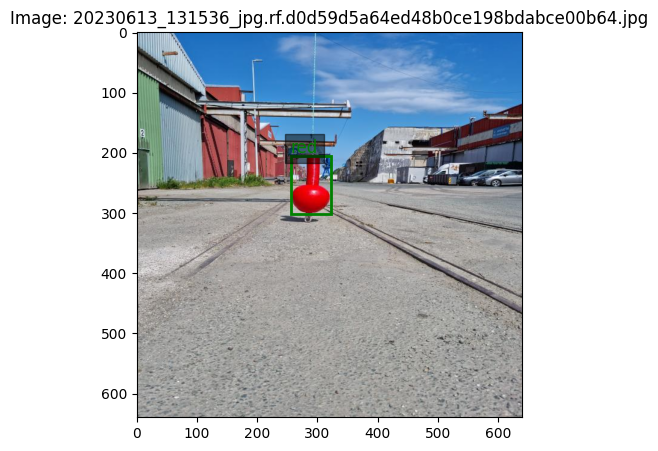

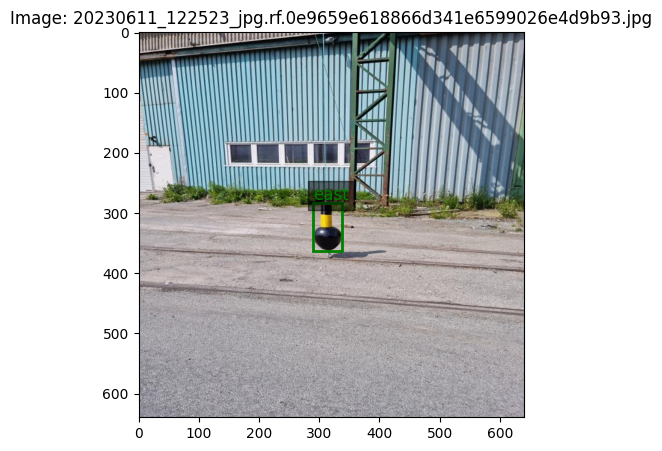

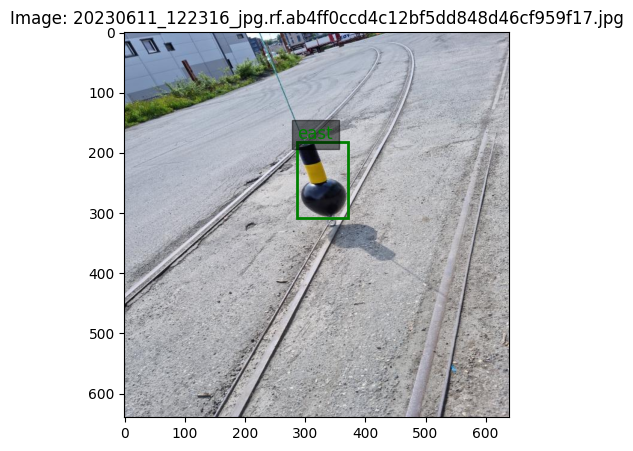

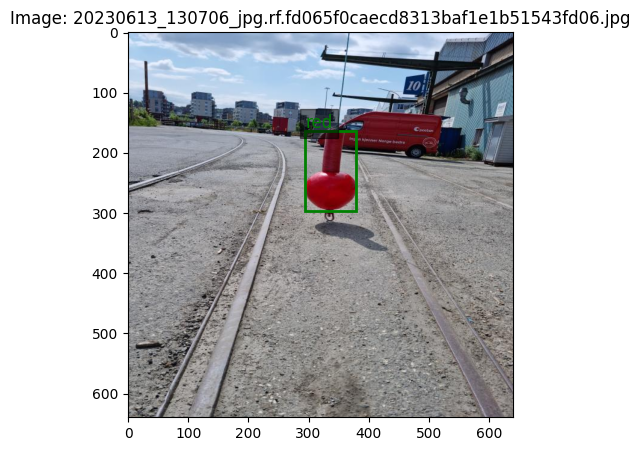

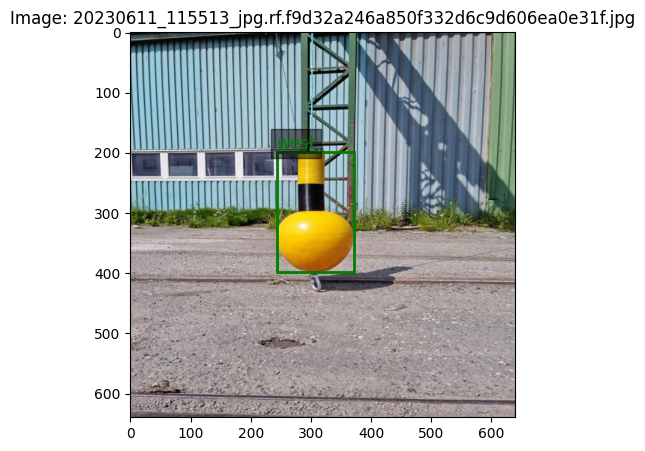

In [8]:
# Pass class names by index
class_names = ["east", "green", "red", "west"]  
plot_sample_with_bboxes(images_train_dir, annotations_train_dir, class_names, num_samples=5)

# Prepare Dataset

In [9]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class BuoyDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_size, transform=None, original_image_size = 640):
        """
        Args:
            images_dir (str): Path to the folder containing buoy images.
            annotations_dir (str): Path to the folder containing YOLO-style annotations.
            image_size (int): Target size for resizing images (image_size x image_size).
            transform (callable, optional): Transformations for images.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.image_size = image_size
        self.transform = transform

        # List all image files
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image and corresponding annotation file
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        annotation_path = os.path.join(self.annotations_dir, os.path.splitext(img_file)[0] + '.txt')

        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Load and parse annotation
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        bboxes = []
        labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized YOLO coordinates to pixel coordinates
            x_min = (x_center - width / 2)
            y_min = (y_center - height / 2)
            x_max = (x_center + width / 2) 
            y_max = (y_center + height / 2) 

            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        # Convert to tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return image, labels, bboxes

## Augmentations 

In [10]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

batch_size = 128
img_resize = 128
# Define transforms
transform = Compose([
    Resize((img_resize, img_resize)),  # Resize images to a fixed size
    ToTensor(),          # Convert to PyTorch tensor
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Train dataset
train_dataset = BuoyDataset(images_train_dir, annotations_train_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test dataset
test_dataset = BuoyDataset(images_test_dir, annotations_test_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
test_datalaoder = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Valdiation dataset
valid_dataset = BuoyDataset(images_valid_dir, annotations_valid_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# Check dataset length
print(train_dataset.__len__())
print(test_dataset.__len__())
print(valid_dataset.__len__())

521
75
148


In [12]:
# Check dataset image
idx = 0
print(train_dataset.__getitem__(idx)[0])
print(train_dataset.__getitem__(idx)[0].shape)

tensor([[[ 0.2392,  0.2157,  0.2392,  ..., -0.7412, -0.7490, -0.7490],
         [ 0.2392,  0.2314,  0.2314,  ..., -0.7412, -0.7490, -0.7490],
         [ 0.2157,  0.2235,  0.2392,  ..., -0.7412, -0.7412, -0.7412],
         ...,
         [ 0.2392,  0.1922,  0.1765,  ...,  0.2157,  0.1294,  0.1529],
         [ 0.2471,  0.2078,  0.2235,  ...,  0.0980,  0.1529,  0.2784],
         [ 0.0902,  0.2392,  0.2941,  ..., -0.0431,  0.0118,  0.1137]],

        [[ 0.4196,  0.3961,  0.4196,  ..., -0.1373, -0.1451, -0.1451],
         [ 0.4196,  0.4118,  0.4118,  ..., -0.1373, -0.1451, -0.1451],
         [ 0.4039,  0.4118,  0.4196,  ..., -0.1373, -0.1373, -0.1373],
         ...,
         [ 0.2549,  0.2078,  0.1922,  ...,  0.2157,  0.1294,  0.1529],
         [ 0.2627,  0.2235,  0.2314,  ...,  0.0980,  0.1529,  0.2784],
         [ 0.1059,  0.2549,  0.3020,  ..., -0.0431,  0.0118,  0.1137]],

        [[ 0.5451,  0.5216,  0.5451,  ...,  0.5059,  0.4980,  0.4980],
         [ 0.5451,  0.5373,  0.5373,  ...,  0

In [13]:
# Check dataset label
idx = 0
print(train_dataset.__getitem__(idx)[1])

tensor([2])


In [14]:
# Check dataset normalized Bounding Box
idx = 0
print(train_dataset.__getitem__(idx)[2])

tensor([[0.3996, 0.3215, 0.5035, 0.4707]])


## Model


In [15]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

class VGG16BuoyDetector(nn.Module):
    def __init__(self, n_classes=4, pretrained=True, freeze_features=True):
        super().__init__()
        
        # Load pretrained VGG16
        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features
        
        # Calculate features output size for 128x128 input
        # VGG16 has 5 max pooling layers, so spatial dimensions are divided by 2^5
        self.feature_output_size = (128 // 32) ** 2 * 512  # 128 is img_resize
        
        # Freeze feature layers if specified
        if freeze_features:
            for param in self.features.parameters():
                param.requires_grad = False
        
        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(self.feature_output_size, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(p=0.5)
        )
        
        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(512, n_classes)
        )
        
        # Bounding box regression head
        self.bbox_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 4)  # normalized x_min, y_min, x_max, y_max
        )
        
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.shared_fc(x)
        
        class_output = self.classification_head(x)
        bbox_output = self.bbox_head(x)
        bbox_output = torch.sigmoid(bbox_output)  # Ensure bbox coordinates are between 0 and 1
        
        return class_output, bbox_output
    
    def _initialize_weights(self):
        for module in [self.shared_fc, self.classification_head, self.bbox_head]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

class BuoyDetectionLoss(nn.Module):
    def __init__(self, class_weight=1.0, bbox_weight=1.0):
        super().__init__()
        self.class_weight = class_weight
        self.bbox_weight = bbox_weight
        self.class_criterion = nn.CrossEntropyLoss()
        self.bbox_criterion = nn.SmoothL1Loss()

    def forward(self, class_pred, bbox_pred, class_target, bbox_target):
        class_loss = self.class_criterion(class_pred, class_target)
        bbox_loss = self.bbox_criterion(bbox_pred, bbox_target)
        
        total_loss = self.class_weight * class_loss + self.bbox_weight * bbox_loss
        return total_loss, class_loss, bbox_loss

2024-12-01 17:25:11.759296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 17:25:11.768684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 17:25:11.781353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 17:25:11.784868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 17:25:11.793737: I tensorflow/core/platform/cpu_feature_guar

## Train

In [16]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    best_valid_loss = float('inf')
    writer = SummaryWriter(log_dir="runs/object_detection")  # Initialize TensorBoard writer

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        class_train_losses = []
        bbox_train_losses = []

        for images, labels, bboxes in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            # Handle multiple objects: take first object for now
            labels = labels[:, 0]  # Take first object's class
            bboxes = bboxes[:, 0]  # Take first object's bbox

            optimizer.zero_grad()
            class_pred, bbox_pred = model(images)

            total_loss, class_loss, bbox_loss = criterion(
                class_pred, bbox_pred, labels, bboxes
            )

            total_loss.backward()
            optimizer.step()

            train_losses.append(total_loss.item())
            class_train_losses.append(class_loss.item())
            bbox_train_losses.append(bbox_loss.item())

        # Validation phase
        model.eval()
        valid_losses = []
        class_valid_losses = []
        bbox_valid_losses = []

        with torch.no_grad():
            for images, labels, bboxes in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device)

                # Handle multiple objects: take first object for now
                labels = labels[:, 0]
                bboxes = bboxes[:, 0]

                class_pred, bbox_pred = model(images)
                total_loss, class_loss, bbox_loss = criterion(
                    class_pred, bbox_pred, labels, bboxes
                )

                valid_losses.append(total_loss.item())
                class_valid_losses.append(class_loss.item())
                bbox_valid_losses.append(bbox_loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_valid_loss = sum(valid_losses) / len(valid_losses)
        avg_class_train_loss = sum(class_train_losses) / len(class_train_losses)
        avg_bbox_train_loss = sum(bbox_train_losses) / len(bbox_train_losses)
        avg_class_valid_loss = sum(class_valid_losses) / len(class_valid_losses)
        avg_bbox_valid_loss = sum(bbox_valid_losses) / len(bbox_valid_losses)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_valid_loss:.4f}')
        print(f'Class Training Loss: {avg_class_train_loss:.4f}, BBox Training Loss: {avg_bbox_train_loss:.4f}')
        print(f'Class Validation Loss: {avg_class_valid_loss:.4f}, BBox Validation Loss: {avg_bbox_valid_loss:.4f}')

        # Log metrics to TensorBoard
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Valid", avg_valid_loss, epoch)
        writer.add_scalar("Loss/Class_Train", avg_class_train_loss, epoch)
        writer.add_scalar("Loss/BBox_Train", avg_bbox_train_loss, epoch)
        writer.add_scalar("Loss/Class_Valid", avg_class_valid_loss, epoch)
        writer.add_scalar("Loss/BBox_Valid", avg_bbox_valid_loss, epoch)

        # Save best model
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            save_path = f'runs/best_model_epoch.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_valid_loss': best_valid_loss,
            }, save_path)

    writer.close()  # Close the TensorBoard writer

    ### To lauch tensor board run on the terminal: tensorboard --logdir=runs


### Init Model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Initialize model with 4 classes
model = VGG16BuoyDetector(n_classes=4).to(device)

Using device: cuda


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 85.50 MiB is free. Process 114685 has 5.49 GiB memory in use. Including non-PyTorch memory, this process has 142.00 MiB memory in use. Of the allocated memory 57.01 MiB is allocated by PyTorch, and 4.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Loss Criterium

In [ ]:
criterion = BuoyDetectionLoss(class_weight=0.1, bbox_weight=1.0)

### Optmizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [ ]:
num_epochs = 150
train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs, device)

Epoch 1/150: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 1/150:
Average Training Loss: 0.8176
Average Validation Loss: 0.1397
Class Training Loss: 7.5869, BBox Training Loss: 0.0589
Class Validation Loss: 1.0353, BBox Validation Loss: 0.0362


Epoch 2/150: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 2/150:
Average Training Loss: 0.3084
Average Validation Loss: 0.1394
Class Training Loss: 2.5626, BBox Training Loss: 0.0522
Class Validation Loss: 1.0449, BBox Validation Loss: 0.0349


Epoch 3/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 3/150:
Average Training Loss: 0.1868
Average Validation Loss: 0.0963
Class Training Loss: 1.3934, BBox Training Loss: 0.0474
Class Validation Loss: 0.6692, BBox Validation Loss: 0.0294


Epoch 4/150: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 4/150:
Average Training Loss: 0.1123
Average Validation Loss: 0.0571
Class Training Loss: 0.7020, BBox Training Loss: 0.0421
Class Validation Loss: 0.3495, BBox Validation Loss: 0.0222


Epoch 5/150: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 5/150:
Average Training Loss: 0.0899
Average Validation Loss: 0.0517
Class Training Loss: 0.4946, BBox Training Loss: 0.0404
Class Validation Loss: 0.2840, BBox Validation Loss: 0.0233


Epoch 6/150: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 6/150:
Average Training Loss: 0.0944
Average Validation Loss: 0.0321
Class Training Loss: 0.5977, BBox Training Loss: 0.0346
Class Validation Loss: 0.1240, BBox Validation Loss: 0.0197


Epoch 7/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 7/150:
Average Training Loss: 0.0489
Average Validation Loss: 0.0265
Class Training Loss: 0.1876, BBox Training Loss: 0.0302
Class Validation Loss: 0.0771, BBox Validation Loss: 0.0188


Epoch 8/150: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 8/150:
Average Training Loss: 0.0400
Average Validation Loss: 0.0255
Class Training Loss: 0.1123, BBox Training Loss: 0.0288
Class Validation Loss: 0.0890, BBox Validation Loss: 0.0166


Epoch 9/150: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 9/150:
Average Training Loss: 0.0386
Average Validation Loss: 0.0262
Class Training Loss: 0.1121, BBox Training Loss: 0.0274
Class Validation Loss: 0.1026, BBox Validation Loss: 0.0160


Epoch 10/150: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 10/150:
Average Training Loss: 0.0331
Average Validation Loss: 0.0191
Class Training Loss: 0.0627, BBox Training Loss: 0.0268
Class Validation Loss: 0.0452, BBox Validation Loss: 0.0145


Epoch 11/150: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 11/150:
Average Training Loss: 0.0327
Average Validation Loss: 0.0231
Class Training Loss: 0.0729, BBox Training Loss: 0.0254
Class Validation Loss: 0.1234, BBox Validation Loss: 0.0107


Epoch 12/150: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 12/150:
Average Training Loss: 0.0256
Average Validation Loss: 0.0210
Class Training Loss: 0.0431, BBox Training Loss: 0.0213
Class Validation Loss: 0.1272, BBox Validation Loss: 0.0083


Epoch 13/150: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 13/150:
Average Training Loss: 0.0237
Average Validation Loss: 0.0169
Class Training Loss: 0.0361, BBox Training Loss: 0.0201
Class Validation Loss: 0.1214, BBox Validation Loss: 0.0048


Epoch 14/150: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Epoch 14/150:
Average Training Loss: 0.0155
Average Validation Loss: 0.0149
Class Training Loss: 0.0280, BBox Training Loss: 0.0127
Class Validation Loss: 0.0544, BBox Validation Loss: 0.0094


Epoch 15/150: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Epoch 15/150:
Average Training Loss: 0.0115
Average Validation Loss: 0.0120
Class Training Loss: 0.0204, BBox Training Loss: 0.0094
Class Validation Loss: 0.0370, BBox Validation Loss: 0.0083


Epoch 16/150: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


Epoch 16/150:
Average Training Loss: 0.0117
Average Validation Loss: 0.0086
Class Training Loss: 0.0473, BBox Training Loss: 0.0070
Class Validation Loss: 0.0316, BBox Validation Loss: 0.0055


Epoch 17/150: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 17/150:
Average Training Loss: 0.0083
Average Validation Loss: 0.0114
Class Training Loss: 0.0229, BBox Training Loss: 0.0060
Class Validation Loss: 0.0676, BBox Validation Loss: 0.0046


Epoch 18/150: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Epoch 18/150:
Average Training Loss: 0.0086
Average Validation Loss: 0.0140
Class Training Loss: 0.0400, BBox Training Loss: 0.0046
Class Validation Loss: 0.1003, BBox Validation Loss: 0.0039


Epoch 19/150: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Epoch 19/150:
Average Training Loss: 0.0093
Average Validation Loss: 0.0070
Class Training Loss: 0.0451, BBox Training Loss: 0.0048
Class Validation Loss: 0.0262, BBox Validation Loss: 0.0044


Epoch 20/150: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Epoch 20/150:
Average Training Loss: 0.0067
Average Validation Loss: 0.0070
Class Training Loss: 0.0232, BBox Training Loss: 0.0044
Class Validation Loss: 0.0295, BBox Validation Loss: 0.0040


Epoch 21/150: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Epoch 21/150:
Average Training Loss: 0.0064
Average Validation Loss: 0.0197
Class Training Loss: 0.0249, BBox Training Loss: 0.0039
Class Validation Loss: 0.1587, BBox Validation Loss: 0.0038


Epoch 22/150: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch 22/150:
Average Training Loss: 0.0105
Average Validation Loss: 0.0135
Class Training Loss: 0.0646, BBox Training Loss: 0.0040
Class Validation Loss: 0.1021, BBox Validation Loss: 0.0033


Epoch 23/150: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


Epoch 23/150:
Average Training Loss: 0.0071
Average Validation Loss: 0.0073
Class Training Loss: 0.0332, BBox Training Loss: 0.0038
Class Validation Loss: 0.0349, BBox Validation Loss: 0.0038


Epoch 24/150: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 24/150:
Average Training Loss: 0.0050
Average Validation Loss: 0.0064
Class Training Loss: 0.0107, BBox Training Loss: 0.0039
Class Validation Loss: 0.0301, BBox Validation Loss: 0.0034


Epoch 25/150: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 25/150:
Average Training Loss: 0.0066
Average Validation Loss: 0.0116
Class Training Loss: 0.0309, BBox Training Loss: 0.0035
Class Validation Loss: 0.0775, BBox Validation Loss: 0.0038


Epoch 26/150: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 26/150:
Average Training Loss: 0.0047
Average Validation Loss: 0.0134
Class Training Loss: 0.0098, BBox Training Loss: 0.0038
Class Validation Loss: 0.0955, BBox Validation Loss: 0.0038


Epoch 27/150: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 27/150:
Average Training Loss: 0.0048
Average Validation Loss: 0.0081
Class Training Loss: 0.0133, BBox Training Loss: 0.0035
Class Validation Loss: 0.0447, BBox Validation Loss: 0.0036


Epoch 28/150: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 28/150:
Average Training Loss: 0.0038
Average Validation Loss: 0.0103
Class Training Loss: 0.0031, BBox Training Loss: 0.0034
Class Validation Loss: 0.0688, BBox Validation Loss: 0.0035


Epoch 29/150: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 29/150:
Average Training Loss: 0.0041
Average Validation Loss: 0.0108
Class Training Loss: 0.0063, BBox Training Loss: 0.0035
Class Validation Loss: 0.0715, BBox Validation Loss: 0.0037


Epoch 30/150: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 30/150:
Average Training Loss: 0.0044
Average Validation Loss: 0.0062
Class Training Loss: 0.0116, BBox Training Loss: 0.0033
Class Validation Loss: 0.0265, BBox Validation Loss: 0.0035


Epoch 31/150: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 31/150:
Average Training Loss: 0.0034
Average Validation Loss: 0.0056
Class Training Loss: 0.0060, BBox Training Loss: 0.0028
Class Validation Loss: 0.0224, BBox Validation Loss: 0.0033


Epoch 32/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 32/150:
Average Training Loss: 0.0036
Average Validation Loss: 0.0074
Class Training Loss: 0.0077, BBox Training Loss: 0.0028
Class Validation Loss: 0.0383, BBox Validation Loss: 0.0035


Epoch 33/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 33/150:
Average Training Loss: 0.0030
Average Validation Loss: 0.0068
Class Training Loss: 0.0035, BBox Training Loss: 0.0026
Class Validation Loss: 0.0319, BBox Validation Loss: 0.0036


Epoch 34/150: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 34/150:
Average Training Loss: 0.0029
Average Validation Loss: 0.0070
Class Training Loss: 0.0036, BBox Training Loss: 0.0025
Class Validation Loss: 0.0337, BBox Validation Loss: 0.0036


Epoch 35/150: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 35/150:
Average Training Loss: 0.0027
Average Validation Loss: 0.0103
Class Training Loss: 0.0025, BBox Training Loss: 0.0025
Class Validation Loss: 0.0669, BBox Validation Loss: 0.0036


Epoch 36/150: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 36/150:
Average Training Loss: 0.0039
Average Validation Loss: 0.0061
Class Training Loss: 0.0079, BBox Training Loss: 0.0031
Class Validation Loss: 0.0312, BBox Validation Loss: 0.0030


Epoch 37/150: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 37/150:
Average Training Loss: 0.0037
Average Validation Loss: 0.0074
Class Training Loss: 0.0096, BBox Training Loss: 0.0027
Class Validation Loss: 0.0467, BBox Validation Loss: 0.0027


Epoch 38/150: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 38/150:
Average Training Loss: 0.0053
Average Validation Loss: 0.0122
Class Training Loss: 0.0281, BBox Training Loss: 0.0025
Class Validation Loss: 0.0953, BBox Validation Loss: 0.0027


Epoch 39/150: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 39/150:
Average Training Loss: 0.0070
Average Validation Loss: 0.0047
Class Training Loss: 0.0463, BBox Training Loss: 0.0024
Class Validation Loss: 0.0184, BBox Validation Loss: 0.0028


Epoch 40/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 40/150:
Average Training Loss: 0.0050
Average Validation Loss: 0.0186
Class Training Loss: 0.0238, BBox Training Loss: 0.0026
Class Validation Loss: 0.1585, BBox Validation Loss: 0.0028


Epoch 41/150: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 41/150:
Average Training Loss: 0.0053
Average Validation Loss: 0.0077
Class Training Loss: 0.0241, BBox Training Loss: 0.0029
Class Validation Loss: 0.0457, BBox Validation Loss: 0.0032


Epoch 42/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 42/150:
Average Training Loss: 0.0066
Average Validation Loss: 0.0069
Class Training Loss: 0.0360, BBox Training Loss: 0.0030
Class Validation Loss: 0.0322, BBox Validation Loss: 0.0037


Epoch 43/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 43/150:
Average Training Loss: 0.0103
Average Validation Loss: 0.0057
Class Training Loss: 0.0685, BBox Training Loss: 0.0035
Class Validation Loss: 0.0264, BBox Validation Loss: 0.0030


Epoch 44/150: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 44/150:
Average Training Loss: 0.0192
Average Validation Loss: 0.0188
Class Training Loss: 0.1579, BBox Training Loss: 0.0034
Class Validation Loss: 0.1585, BBox Validation Loss: 0.0030


Epoch 45/150: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 45/150:
Average Training Loss: 0.0140
Average Validation Loss: 0.0095
Class Training Loss: 0.1041, BBox Training Loss: 0.0035
Class Validation Loss: 0.0594, BBox Validation Loss: 0.0036


Epoch 46/150: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 46/150:
Average Training Loss: 0.0098
Average Validation Loss: 0.0071
Class Training Loss: 0.0677, BBox Training Loss: 0.0030
Class Validation Loss: 0.0368, BBox Validation Loss: 0.0034


Epoch 47/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 47/150:
Average Training Loss: 0.0091
Average Validation Loss: 0.0305
Class Training Loss: 0.0529, BBox Training Loss: 0.0038
Class Validation Loss: 0.2721, BBox Validation Loss: 0.0033


Epoch 48/150: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 48/150:
Average Training Loss: 0.0120
Average Validation Loss: 0.0174
Class Training Loss: 0.0754, BBox Training Loss: 0.0044
Class Validation Loss: 0.1399, BBox Validation Loss: 0.0034


Epoch 49/150: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 49/150:
Average Training Loss: 0.0253
Average Validation Loss: 0.0076
Class Training Loss: 0.2113, BBox Training Loss: 0.0042
Class Validation Loss: 0.0350, BBox Validation Loss: 0.0041


Epoch 50/150: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 50/150:
Average Training Loss: 0.0141
Average Validation Loss: 0.0082
Class Training Loss: 0.0962, BBox Training Loss: 0.0045
Class Validation Loss: 0.0516, BBox Validation Loss: 0.0030


Epoch 51/150: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 51/150:
Average Training Loss: 0.0051
Average Validation Loss: 0.0107
Class Training Loss: 0.0139, BBox Training Loss: 0.0037
Class Validation Loss: 0.0781, BBox Validation Loss: 0.0029


Epoch 52/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 52/150:
Average Training Loss: 0.0078
Average Validation Loss: 0.0113
Class Training Loss: 0.0423, BBox Training Loss: 0.0036
Class Validation Loss: 0.0828, BBox Validation Loss: 0.0030


Epoch 53/150: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 53/150:
Average Training Loss: 0.0053
Average Validation Loss: 0.0045
Class Training Loss: 0.0199, BBox Training Loss: 0.0033
Class Validation Loss: 0.0205, BBox Validation Loss: 0.0025


Epoch 54/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 54/150:
Average Training Loss: 0.0124
Average Validation Loss: 0.0053
Class Training Loss: 0.0910, BBox Training Loss: 0.0033
Class Validation Loss: 0.0248, BBox Validation Loss: 0.0028


Epoch 55/150: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 55/150:
Average Training Loss: 0.0111
Average Validation Loss: 0.0188
Class Training Loss: 0.0828, BBox Training Loss: 0.0028
Class Validation Loss: 0.1659, BBox Validation Loss: 0.0022


Epoch 56/150: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 56/150:
Average Training Loss: 0.0093
Average Validation Loss: 0.0052
Class Training Loss: 0.0635, BBox Training Loss: 0.0029
Class Validation Loss: 0.0208, BBox Validation Loss: 0.0031


Epoch 57/150: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 57/150:
Average Training Loss: 0.0084
Average Validation Loss: 0.0045
Class Training Loss: 0.0532, BBox Training Loss: 0.0031
Class Validation Loss: 0.0168, BBox Validation Loss: 0.0028


Epoch 58/150: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 58/150:
Average Training Loss: 0.0029
Average Validation Loss: 0.0040
Class Training Loss: 0.0013, BBox Training Loss: 0.0028
Class Validation Loss: 0.0179, BBox Validation Loss: 0.0022


Epoch 59/150: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 59/150:
Average Training Loss: 0.0089
Average Validation Loss: 0.0032
Class Training Loss: 0.0632, BBox Training Loss: 0.0026
Class Validation Loss: 0.0120, BBox Validation Loss: 0.0020


Epoch 60/150: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 60/150:
Average Training Loss: 0.0079
Average Validation Loss: 0.0064
Class Training Loss: 0.0495, BBox Training Loss: 0.0030
Class Validation Loss: 0.0415, BBox Validation Loss: 0.0022


Epoch 61/150: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 61/150:
Average Training Loss: 0.0111
Average Validation Loss: 0.0066
Class Training Loss: 0.0879, BBox Training Loss: 0.0024
Class Validation Loss: 0.0406, BBox Validation Loss: 0.0025


Epoch 62/150: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 62/150:
Average Training Loss: 0.0062
Average Validation Loss: 0.0057
Class Training Loss: 0.0352, BBox Training Loss: 0.0027
Class Validation Loss: 0.0324, BBox Validation Loss: 0.0025


Epoch 63/150: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 63/150:
Average Training Loss: 0.0032
Average Validation Loss: 0.0070
Class Training Loss: 0.0069, BBox Training Loss: 0.0025
Class Validation Loss: 0.0451, BBox Validation Loss: 0.0025


Epoch 64/150: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 64/150:
Average Training Loss: 0.0036
Average Validation Loss: 0.0242
Class Training Loss: 0.0126, BBox Training Loss: 0.0024
Class Validation Loss: 0.2206, BBox Validation Loss: 0.0022


Epoch 65/150: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 65/150:
Average Training Loss: 0.0048
Average Validation Loss: 0.0042
Class Training Loss: 0.0232, BBox Training Loss: 0.0025
Class Validation Loss: 0.0222, BBox Validation Loss: 0.0020


Epoch 66/150: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 66/150:
Average Training Loss: 0.0027
Average Validation Loss: 0.0032
Class Training Loss: 0.0042, BBox Training Loss: 0.0023
Class Validation Loss: 0.0089, BBox Validation Loss: 0.0023


Epoch 67/150: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 67/150:
Average Training Loss: 0.0026
Average Validation Loss: 0.0044
Class Training Loss: 0.0013, BBox Training Loss: 0.0024
Class Validation Loss: 0.0212, BBox Validation Loss: 0.0023


Epoch 68/150: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 68/150:
Average Training Loss: 0.0024
Average Validation Loss: 0.0020
Class Training Loss: 0.0004, BBox Training Loss: 0.0024
Class Validation Loss: 0.0032, BBox Validation Loss: 0.0017


Epoch 69/150: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 69/150:
Average Training Loss: 0.0022
Average Validation Loss: 0.0019
Class Training Loss: 0.0018, BBox Training Loss: 0.0020
Class Validation Loss: 0.0024, BBox Validation Loss: 0.0017


Epoch 70/150: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 70/150:
Average Training Loss: 0.0023
Average Validation Loss: 0.0021
Class Training Loss: 0.0001, BBox Training Loss: 0.0022
Class Validation Loss: 0.0047, BBox Validation Loss: 0.0016


Epoch 71/150: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 71/150:
Average Training Loss: 0.0027
Average Validation Loss: 0.0018
Class Training Loss: 0.0074, BBox Training Loss: 0.0019
Class Validation Loss: 0.0017, BBox Validation Loss: 0.0016


Epoch 72/150: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 72/150:
Average Training Loss: 0.0021
Average Validation Loss: 0.0019
Class Training Loss: 0.0022, BBox Training Loss: 0.0018
Class Validation Loss: 0.0011, BBox Validation Loss: 0.0018


Epoch 73/150: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 73/150:
Average Training Loss: 0.0063
Average Validation Loss: 0.0023
Class Training Loss: 0.0416, BBox Training Loss: 0.0022
Class Validation Loss: 0.0050, BBox Validation Loss: 0.0018


Epoch 74/150: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 74/150:
Average Training Loss: 0.0030
Average Validation Loss: 0.0182
Class Training Loss: 0.0106, BBox Training Loss: 0.0019
Class Validation Loss: 0.1669, BBox Validation Loss: 0.0015


Epoch 75/150: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 75/150:
Average Training Loss: 0.0089
Average Validation Loss: 0.0038
Class Training Loss: 0.0705, BBox Training Loss: 0.0019
Class Validation Loss: 0.0233, BBox Validation Loss: 0.0015


Epoch 76/150: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 76/150:
Average Training Loss: 0.0102
Average Validation Loss: 0.0132
Class Training Loss: 0.0821, BBox Training Loss: 0.0020
Class Validation Loss: 0.1137, BBox Validation Loss: 0.0018


Epoch 77/150: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 77/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0226
Class Training Loss: 0.0003, BBox Training Loss: 0.0016
Class Validation Loss: 0.2121, BBox Validation Loss: 0.0014


Epoch 78/150: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 78/150:
Average Training Loss: 0.0052
Average Validation Loss: 0.0341
Class Training Loss: 0.0344, BBox Training Loss: 0.0017
Class Validation Loss: 0.3274, BBox Validation Loss: 0.0014


Epoch 79/150: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 79/150:
Average Training Loss: 0.0020
Average Validation Loss: 0.0082
Class Training Loss: 0.0004, BBox Training Loss: 0.0020
Class Validation Loss: 0.0680, BBox Validation Loss: 0.0014


Epoch 80/150: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 80/150:
Average Training Loss: 0.0021
Average Validation Loss: 0.0087
Class Training Loss: 0.0028, BBox Training Loss: 0.0019
Class Validation Loss: 0.0730, BBox Validation Loss: 0.0014


Epoch 81/150: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch 81/150:
Average Training Loss: 0.0017
Average Validation Loss: 0.0086
Class Training Loss: 0.0014, BBox Training Loss: 0.0016
Class Validation Loss: 0.0685, BBox Validation Loss: 0.0017


Epoch 82/150: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 82/150:
Average Training Loss: 0.0042
Average Validation Loss: 0.0085
Class Training Loss: 0.0245, BBox Training Loss: 0.0017
Class Validation Loss: 0.0698, BBox Validation Loss: 0.0015


Epoch 83/150: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 83/150:
Average Training Loss: 0.0023
Average Validation Loss: 0.0254
Class Training Loss: 0.0053, BBox Training Loss: 0.0018
Class Validation Loss: 0.2377, BBox Validation Loss: 0.0016


Epoch 84/150: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 84/150:
Average Training Loss: 0.0019
Average Validation Loss: 0.0069
Class Training Loss: 0.0024, BBox Training Loss: 0.0016
Class Validation Loss: 0.0549, BBox Validation Loss: 0.0014


Epoch 85/150: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 85/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0068
Class Training Loss: 0.0002, BBox Training Loss: 0.0016
Class Validation Loss: 0.0526, BBox Validation Loss: 0.0015


Epoch 86/150: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 86/150:
Average Training Loss: 0.0023
Average Validation Loss: 0.0079
Class Training Loss: 0.0036, BBox Training Loss: 0.0019
Class Validation Loss: 0.0625, BBox Validation Loss: 0.0016


Epoch 87/150: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 87/150:
Average Training Loss: 0.0015
Average Validation Loss: 0.0235
Class Training Loss: 0.0010, BBox Training Loss: 0.0014
Class Validation Loss: 0.2167, BBox Validation Loss: 0.0018


Epoch 88/150: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 88/150:
Average Training Loss: 0.0021
Average Validation Loss: 0.0060
Class Training Loss: 0.0044, BBox Training Loss: 0.0017
Class Validation Loss: 0.0432, BBox Validation Loss: 0.0017


Epoch 89/150: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 89/150:
Average Training Loss: 0.0080
Average Validation Loss: 0.0480
Class Training Loss: 0.0634, BBox Training Loss: 0.0016
Class Validation Loss: 0.4684, BBox Validation Loss: 0.0012


Epoch 90/150: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 90/150:
Average Training Loss: 0.0035
Average Validation Loss: 0.0331
Class Training Loss: 0.0181, BBox Training Loss: 0.0017
Class Validation Loss: 0.3166, BBox Validation Loss: 0.0014


Epoch 91/150: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 91/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0135
Class Training Loss: 0.0001, BBox Training Loss: 0.0016
Class Validation Loss: 0.1201, BBox Validation Loss: 0.0015


Epoch 92/150: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 92/150:
Average Training Loss: 0.0014
Average Validation Loss: 0.0136
Class Training Loss: 0.0002, BBox Training Loss: 0.0014
Class Validation Loss: 0.1229, BBox Validation Loss: 0.0013


Epoch 93/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 93/150:
Average Training Loss: 0.0017
Average Validation Loss: 0.0207
Class Training Loss: 0.0016, BBox Training Loss: 0.0016
Class Validation Loss: 0.1908, BBox Validation Loss: 0.0016


Epoch 94/150: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 94/150:
Average Training Loss: 0.0029
Average Validation Loss: 0.0082
Class Training Loss: 0.0159, BBox Training Loss: 0.0013
Class Validation Loss: 0.0678, BBox Validation Loss: 0.0014


Epoch 95/150: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 95/150:
Average Training Loss: 0.0018
Average Validation Loss: 0.0090
Class Training Loss: 0.0048, BBox Training Loss: 0.0013
Class Validation Loss: 0.0764, BBox Validation Loss: 0.0013


Epoch 96/150: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 96/150:
Average Training Loss: 0.0019
Average Validation Loss: 0.0131
Class Training Loss: 0.0032, BBox Training Loss: 0.0016
Class Validation Loss: 0.1155, BBox Validation Loss: 0.0016


Epoch 97/150: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 97/150:
Average Training Loss: 0.0035
Average Validation Loss: 0.0079
Class Training Loss: 0.0200, BBox Training Loss: 0.0015
Class Validation Loss: 0.0655, BBox Validation Loss: 0.0013


Epoch 98/150: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 98/150:
Average Training Loss: 0.0034
Average Validation Loss: 0.0035
Class Training Loss: 0.0175, BBox Training Loss: 0.0017
Class Validation Loss: 0.0224, BBox Validation Loss: 0.0013


Epoch 99/150: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 99/150:
Average Training Loss: 0.0028
Average Validation Loss: 0.0050
Class Training Loss: 0.0145, BBox Training Loss: 0.0013
Class Validation Loss: 0.0351, BBox Validation Loss: 0.0015


Epoch 100/150: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 100/150:
Average Training Loss: 0.0015
Average Validation Loss: 0.0049
Class Training Loss: 0.0003, BBox Training Loss: 0.0014
Class Validation Loss: 0.0361, BBox Validation Loss: 0.0013


Epoch 101/150: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 101/150:
Average Training Loss: 0.0014
Average Validation Loss: 0.0088
Class Training Loss: 0.0000, BBox Training Loss: 0.0014
Class Validation Loss: 0.0734, BBox Validation Loss: 0.0015


Epoch 102/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 102/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0057
Class Training Loss: 0.0016, BBox Training Loss: 0.0015
Class Validation Loss: 0.0434, BBox Validation Loss: 0.0014


Epoch 103/150: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 103/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0038
Class Training Loss: 0.0011, BBox Training Loss: 0.0015
Class Validation Loss: 0.0226, BBox Validation Loss: 0.0015


Epoch 104/150: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 104/150:
Average Training Loss: 0.0028
Average Validation Loss: 0.0171
Class Training Loss: 0.0100, BBox Training Loss: 0.0018
Class Validation Loss: 0.1535, BBox Validation Loss: 0.0017


Epoch 105/150: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 105/150:
Average Training Loss: 0.0024
Average Validation Loss: 0.0237
Class Training Loss: 0.0094, BBox Training Loss: 0.0015
Class Validation Loss: 0.2211, BBox Validation Loss: 0.0015


Epoch 106/150: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 106/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0090
Class Training Loss: 0.0002, BBox Training Loss: 0.0015
Class Validation Loss: 0.0764, BBox Validation Loss: 0.0014


Epoch 107/150: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 107/150:
Average Training Loss: 0.0013
Average Validation Loss: 0.0238
Class Training Loss: 0.0000, BBox Training Loss: 0.0013
Class Validation Loss: 0.2237, BBox Validation Loss: 0.0014


Epoch 108/150: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 108/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0114
Class Training Loss: 0.0034, BBox Training Loss: 0.0012
Class Validation Loss: 0.1011, BBox Validation Loss: 0.0013


Epoch 109/150: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 109/150:
Average Training Loss: 0.0014
Average Validation Loss: 0.0409
Class Training Loss: 0.0018, BBox Training Loss: 0.0013
Class Validation Loss: 0.3952, BBox Validation Loss: 0.0014


Epoch 110/150: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 110/150:
Average Training Loss: 0.0014
Average Validation Loss: 0.0039
Class Training Loss: 0.0016, BBox Training Loss: 0.0012
Class Validation Loss: 0.0270, BBox Validation Loss: 0.0012


Epoch 111/150: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 111/150:
Average Training Loss: 0.0019
Average Validation Loss: 0.0099
Class Training Loss: 0.0074, BBox Training Loss: 0.0012
Class Validation Loss: 0.0852, BBox Validation Loss: 0.0014


Epoch 112/150: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 112/150:
Average Training Loss: 0.0014
Average Validation Loss: 0.0143
Class Training Loss: 0.0004, BBox Training Loss: 0.0013
Class Validation Loss: 0.1295, BBox Validation Loss: 0.0014


Epoch 113/150: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 113/150:
Average Training Loss: 0.0015
Average Validation Loss: 0.0257
Class Training Loss: 0.0002, BBox Training Loss: 0.0015
Class Validation Loss: 0.2447, BBox Validation Loss: 0.0013


Epoch 114/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 114/150:
Average Training Loss: 0.0029
Average Validation Loss: 0.0222
Class Training Loss: 0.0158, BBox Training Loss: 0.0013
Class Validation Loss: 0.2085, BBox Validation Loss: 0.0013


Epoch 115/150: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 115/150:
Average Training Loss: 0.0025
Average Validation Loss: 0.0061
Class Training Loss: 0.0126, BBox Training Loss: 0.0012
Class Validation Loss: 0.0508, BBox Validation Loss: 0.0011


Epoch 116/150: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 116/150:
Average Training Loss: 0.0019
Average Validation Loss: 0.0090
Class Training Loss: 0.0041, BBox Training Loss: 0.0015
Class Validation Loss: 0.0779, BBox Validation Loss: 0.0012


Epoch 117/150: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 117/150:
Average Training Loss: 0.0025
Average Validation Loss: 0.0117
Class Training Loss: 0.0098, BBox Training Loss: 0.0015
Class Validation Loss: 0.1063, BBox Validation Loss: 0.0011


Epoch 118/150: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 118/150:
Average Training Loss: 0.0081
Average Validation Loss: 0.0076
Class Training Loss: 0.0687, BBox Training Loss: 0.0012
Class Validation Loss: 0.0599, BBox Validation Loss: 0.0016


Epoch 119/150: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 119/150:
Average Training Loss: 0.0542
Average Validation Loss: 0.0098
Class Training Loss: 0.5282, BBox Training Loss: 0.0014
Class Validation Loss: 0.0860, BBox Validation Loss: 0.0012


Epoch 120/150: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 120/150:
Average Training Loss: 0.0028
Average Validation Loss: 0.0251
Class Training Loss: 0.0121, BBox Training Loss: 0.0016
Class Validation Loss: 0.2366, BBox Validation Loss: 0.0014


Epoch 121/150: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 121/150:
Average Training Loss: 0.0151
Average Validation Loss: 0.1431
Class Training Loss: 0.1347, BBox Training Loss: 0.0017
Class Validation Loss: 1.4158, BBox Validation Loss: 0.0015


Epoch 122/150: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 122/150:
Average Training Loss: 0.0247
Average Validation Loss: 0.0033
Class Training Loss: 0.2316, BBox Training Loss: 0.0016
Class Validation Loss: 0.0199, BBox Validation Loss: 0.0014


Epoch 123/150: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 123/150:
Average Training Loss: 0.0135
Average Validation Loss: 0.0051
Class Training Loss: 0.1190, BBox Training Loss: 0.0016
Class Validation Loss: 0.0346, BBox Validation Loss: 0.0016


Epoch 124/150: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 124/150:
Average Training Loss: 0.0048
Average Validation Loss: 0.0163
Class Training Loss: 0.0283, BBox Training Loss: 0.0020
Class Validation Loss: 0.1461, BBox Validation Loss: 0.0017


Epoch 125/150: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 125/150:
Average Training Loss: 0.0172
Average Validation Loss: 0.0598
Class Training Loss: 0.1539, BBox Training Loss: 0.0018
Class Validation Loss: 0.5840, BBox Validation Loss: 0.0014


Epoch 126/150: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 126/150:
Average Training Loss: 0.0105
Average Validation Loss: 0.0211
Class Training Loss: 0.0893, BBox Training Loss: 0.0016
Class Validation Loss: 0.1970, BBox Validation Loss: 0.0014


Epoch 127/150: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Epoch 127/150:
Average Training Loss: 0.0031
Average Validation Loss: 0.0860
Class Training Loss: 0.0142, BBox Training Loss: 0.0017
Class Validation Loss: 0.8465, BBox Validation Loss: 0.0014


Epoch 128/150: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 128/150:
Average Training Loss: 0.0135
Average Validation Loss: 0.0512
Class Training Loss: 0.1166, BBox Training Loss: 0.0019
Class Validation Loss: 0.4933, BBox Validation Loss: 0.0019


Epoch 129/150: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 129/150:
Average Training Loss: 0.0247
Average Validation Loss: 0.0258
Class Training Loss: 0.2295, BBox Training Loss: 0.0017
Class Validation Loss: 0.2449, BBox Validation Loss: 0.0014


Epoch 130/150: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 130/150:
Average Training Loss: 0.0075
Average Validation Loss: 0.0276
Class Training Loss: 0.0552, BBox Training Loss: 0.0020
Class Validation Loss: 0.2596, BBox Validation Loss: 0.0017


Epoch 131/150: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 131/150:
Average Training Loss: 0.0134
Average Validation Loss: 0.1419
Class Training Loss: 0.1159, BBox Training Loss: 0.0018
Class Validation Loss: 1.4011, BBox Validation Loss: 0.0018


Epoch 132/150: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 132/150:
Average Training Loss: 0.0192
Average Validation Loss: 0.0290
Class Training Loss: 0.1716, BBox Training Loss: 0.0020
Class Validation Loss: 0.2710, BBox Validation Loss: 0.0019


Epoch 133/150: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 133/150:
Average Training Loss: 0.0034
Average Validation Loss: 0.0558
Class Training Loss: 0.0136, BBox Training Loss: 0.0020
Class Validation Loss: 0.5414, BBox Validation Loss: 0.0017


Epoch 134/150: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 134/150:
Average Training Loss: 0.0060
Average Validation Loss: 0.0070
Class Training Loss: 0.0430, BBox Training Loss: 0.0017
Class Validation Loss: 0.0528, BBox Validation Loss: 0.0018


Epoch 135/150: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 135/150:
Average Training Loss: 0.0023
Average Validation Loss: 0.0123
Class Training Loss: 0.0060, BBox Training Loss: 0.0017
Class Validation Loss: 0.1093, BBox Validation Loss: 0.0014


Epoch 136/150: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 136/150:
Average Training Loss: 0.0082
Average Validation Loss: 0.0357
Class Training Loss: 0.0654, BBox Training Loss: 0.0017
Class Validation Loss: 0.3424, BBox Validation Loss: 0.0015


Epoch 137/150: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 137/150:
Average Training Loss: 0.0016
Average Validation Loss: 0.0227
Class Training Loss: 0.0000, BBox Training Loss: 0.0016
Class Validation Loss: 0.2127, BBox Validation Loss: 0.0015


Epoch 138/150: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 138/150:
Average Training Loss: 0.0042
Average Validation Loss: 0.0273
Class Training Loss: 0.0274, BBox Training Loss: 0.0014
Class Validation Loss: 0.2593, BBox Validation Loss: 0.0014


Epoch 139/150: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 139/150:
Average Training Loss: 0.0103
Average Validation Loss: 0.0176
Class Training Loss: 0.0866, BBox Training Loss: 0.0017
Class Validation Loss: 0.1593, BBox Validation Loss: 0.0016


Epoch 140/150: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 140/150:
Average Training Loss: 0.0032
Average Validation Loss: 0.0116
Class Training Loss: 0.0153, BBox Training Loss: 0.0017
Class Validation Loss: 0.0998, BBox Validation Loss: 0.0016


Epoch 141/150: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 141/150:
Average Training Loss: 0.0254
Average Validation Loss: 0.0114
Class Training Loss: 0.2370, BBox Training Loss: 0.0017
Class Validation Loss: 0.0988, BBox Validation Loss: 0.0015


Epoch 142/150: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 142/150:
Average Training Loss: 0.0020
Average Validation Loss: 0.0556
Class Training Loss: 0.0039, BBox Training Loss: 0.0016
Class Validation Loss: 0.5394, BBox Validation Loss: 0.0017


Epoch 143/150: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 143/150:
Average Training Loss: 0.0046
Average Validation Loss: 0.0567
Class Training Loss: 0.0286, BBox Training Loss: 0.0017
Class Validation Loss: 0.5541, BBox Validation Loss: 0.0013


Epoch 144/150: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 144/150:
Average Training Loss: 0.0083
Average Validation Loss: 0.1210
Class Training Loss: 0.0650, BBox Training Loss: 0.0018
Class Validation Loss: 1.1954, BBox Validation Loss: 0.0015


Epoch 145/150: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 145/150:
Average Training Loss: 0.0064
Average Validation Loss: 0.0180
Class Training Loss: 0.0472, BBox Training Loss: 0.0017
Class Validation Loss: 0.1634, BBox Validation Loss: 0.0017


Epoch 146/150: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 146/150:
Average Training Loss: 0.0077
Average Validation Loss: 0.0245
Class Training Loss: 0.0585, BBox Training Loss: 0.0018
Class Validation Loss: 0.2304, BBox Validation Loss: 0.0014


Epoch 147/150: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 147/150:
Average Training Loss: 0.0077
Average Validation Loss: 0.0133
Class Training Loss: 0.0608, BBox Training Loss: 0.0017
Class Validation Loss: 0.1182, BBox Validation Loss: 0.0015


Epoch 148/150: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 148/150:
Average Training Loss: 0.0020
Average Validation Loss: 0.0567
Class Training Loss: 0.0024, BBox Training Loss: 0.0018
Class Validation Loss: 0.5502, BBox Validation Loss: 0.0017


Epoch 149/150: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 149/150:
Average Training Loss: 0.0047
Average Validation Loss: 0.0173
Class Training Loss: 0.0286, BBox Training Loss: 0.0018
Class Validation Loss: 0.1584, BBox Validation Loss: 0.0015


Epoch 150/150: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 150/150:
Average Training Loss: 0.0096
Average Validation Loss: 0.0111
Class Training Loss: 0.0781, BBox Training Loss: 0.0018
Class Validation Loss: 0.0956, BBox Validation Loss: 0.0015


## Evaluate

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from torchvision.transforms import ToPILImage

def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes
    boxes format: [x_min, y_min, x_max, y_max]
    """
    # Calculate intersection coordinates
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    # Calculate intersection area
    if x_max <= x_min or y_max <= y_min:
        return 0.0
    
    intersection = (x_max - x_min) * (y_max - y_min)
    
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0.0

def evaluate_model(model, dataloader, criterion, device, iou_threshold=0.5):
    """
    Evaluate model performance
    """
    model.eval()
    total_loss = 0
    total_class_accuracy = 0
    total_iou = 0
    total_samples = 0
    class_correct = {i: 0 for i in range(4)}  # Assuming 4 classes
    class_total = {i: 0 for i in range(4)}
    
    all_ious = []  # Store all IoUs for distribution analysis
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            
            # Take first object for single-object detection
            labels = labels[:, 0]
            bboxes = bboxes[:, 0]
            
            # Forward pass
            class_pred, bbox_pred = model(images)
            
            # Calculate losses
            total_loss_batch, class_loss, bbox_loss = criterion(
                class_pred, bbox_pred, labels, bboxes
            )
            
            # Calculate classification accuracy
            _, predicted = torch.max(class_pred.data, 1)
            correct = (predicted == labels).sum().item()
            total_class_accuracy += correct
            
            # Update per-class accuracy
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
            
            # Calculate IoU for each prediction
            for i in range(len(bboxes)):
                iou = calculate_iou(
                    bbox_pred[i].cpu().numpy(),
                    bboxes[i].cpu().numpy()
                )
                all_ious.append(iou)
                total_iou += iou
            
            total_samples += images.size(0)
            total_loss += total_loss_batch.item()
    
    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_class_accuracy / total_samples
    avg_iou = total_iou / total_samples
    
    # Calculate per-class accuracy
    class_accuracies = {
        class_id: class_correct[class_id] / class_total[class_id] 
        if class_total[class_id] > 0 else 0
        for class_id in class_total
    }
    
    # Calculate percentage of "good" detections (IoU > threshold)
    good_detections = sum(1 for iou in all_ious if iou > iou_threshold)
    detection_rate = good_detections / len(all_ious)
    
    return {
        'avg_loss': avg_loss,
        'avg_accuracy': avg_accuracy,
        'avg_iou': avg_iou,
        'class_accuracies': class_accuracies,
        'detection_rate': detection_rate,
        'all_ious': all_ious
    }

In [ ]:
# Load trained model
model = VGG16BuoyDetector(n_classes=4).to(device)
checkpoint = torch.load('runs/best_model_epoch.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Create criterion
criterion = BuoyDetectionLoss()

# Evaluate on test set
print("Evaluating on test set...")
test_metrics = evaluate_model(model, test_datalaoder, criterion, device)

# Print metrics
print("\nTest Set Metrics:")
print(f"Average Loss: {test_metrics['avg_loss']:.4f}")
print(f"Average Accuracy: {test_metrics['avg_accuracy']:.4f}")
print(f"Average IoU: {test_metrics['avg_iou']:.4f}")
print(f"Detection Rate (IoU > 0.5): {test_metrics['detection_rate']:.4f}")
print("\nPer-class Accuracies:")
for class_id, accuracy in test_metrics['class_accuracies'].items():
    print(f"Class {class_id}: {accuracy:.4f}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Evaluating on test set...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Test Set Metrics:
Average Loss: 0.0089
Average Accuracy: 1.0000
Average IoU: 0.3596
Detection Rate (IoU > 0.5): 0.3467

Per-class Accuracies:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000


### Check Predictions

In [ ]:
def denormalize_image(normalized_image):
    """
    Denormalize image from [-1, 1] to [0, 1] range
    Args:
        normalized_image: normalized image tensor with mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    
    return normalized_image * std + mean

def visualize_predictions(model, dataloader, device, max_images=None):
    """
    Visualize model predictions with actual and predicted bounding boxes using original images
    """
    model.eval()
    
    # Get first batch
    images, labels, bboxes = next(iter(dataloader))
    batch_size = images.shape[0]
    
    # If max_images is specified, limit the number of images to show
    num_images = min(batch_size, max_images) if max_images else batch_size
    
    # Create figure and axes for subplots
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))
    
    # Define colors for different classes
    class_colors = ['r', 'g', 'b', 'y']
    class_names = ['east', 'red', 'green', 'west']  # Replace with your class names
    
    with torch.no_grad():
        images = images.to(device)
        labels = labels[:, 0]  # Take first object
        bboxes = bboxes[:, 0]  # Take first object
        
        # Get predictions
        class_pred, bbox_pred = model(images)
        _, predicted_class = torch.max(class_pred.data, 1)
        
        for idx in range(num_images):
            # Get original image (denormalized)
            img_tensor = denormalize_image(images[idx].cpu())
            
            # Convert to numpy for matplotlib
            img_numpy = img_tensor.permute(1, 2, 0).numpy()
            
            # Clip values to [0, 1] range
            img_numpy = np.clip(img_numpy, 0, 1)
            
            # Plot original image with ground truth
            axes[idx, 0].imshow(img_numpy)
            axes[idx, 0].set_title(f'Ground Truth (Class: {class_names[labels[idx].item()]})')
            
            # Draw ground truth box
            true_box = bboxes[idx].cpu().numpy()
            true_rect = patches.Rectangle(
                (true_box[0] * img_numpy.shape[1], true_box[1] * img_numpy.shape[0]),
                (true_box[2] - true_box[0]) * img_numpy.shape[1],
                (true_box[3] - true_box[1]) * img_numpy.shape[0],
                linewidth=2,
                edgecolor=class_colors[labels[idx]],
                facecolor='none'
            )
            axes[idx, 0].add_patch(true_rect)
            
            # Plot image with predictions
            axes[idx, 1].imshow(img_numpy)
            
            # Draw predicted box
            pred_box = bbox_pred[idx].cpu().numpy()
            pred_rect = patches.Rectangle(
                (pred_box[0] * img_numpy.shape[1], pred_box[1] * img_numpy.shape[0]),
                (pred_box[2] - pred_box[0]) * img_numpy.shape[1],
                (pred_box[3] - pred_box[1]) * img_numpy.shape[0],
                linewidth=2,
                edgecolor=class_colors[predicted_class[idx]],
                facecolor='none'
            )
            axes[idx, 1].add_patch(pred_rect)
            
            # Calculate and display IoU
            iou = calculate_iou(true_box, pred_box)
            
            # Add confidence score for predicted class
            class_scores = torch.softmax(class_pred[idx], dim=0)
            predicted_score = class_scores[predicted_class[idx]].item()
            
            axes[idx, 1].set_title(
                f'Prediction (Class: {class_names[predicted_class[idx].item()]}, '
                f'Conf: {predicted_score:.2f}, IoU: {iou:.2f})'
            )
            
            # Remove axes
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


Generating visualization...


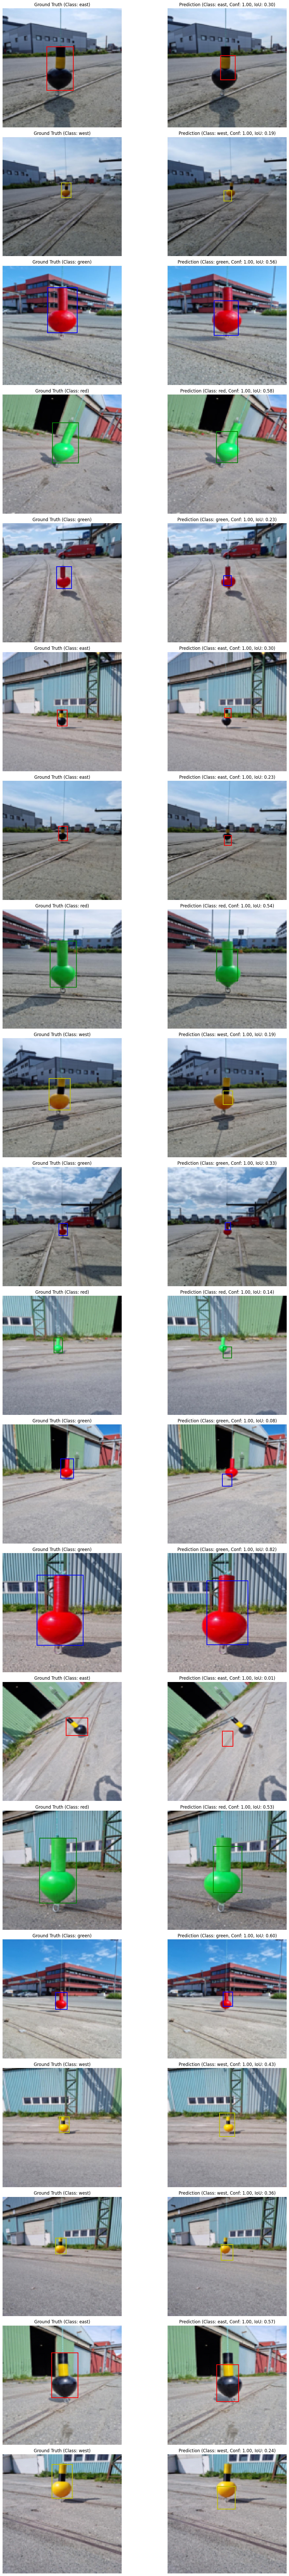

In [ ]:
# Visualize predictions
print("\nGenerating visualization...")
visualize_predictions(model, test_datalaoder, device, max_images=5)

In [ ]:
def plot_iou_distribution(iou_values, bins=50):
    """
    Plots the IoU distribution as a histogram.

    Args:
        iou_values (list or np.array): List of IoU values.
        bins (int): Number of bins for the histogram.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.hist(iou_values, bins=bins, range=(0, 1), color='blue', alpha=0.7, edgecolor='black')
    plt.title('IoU Distribution', fontsize=16)
    plt.xlabel('IoU', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(x=0.5, color='red', linestyle='--', label='IoU Threshold (0.5)')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Plotting IoU distribution...


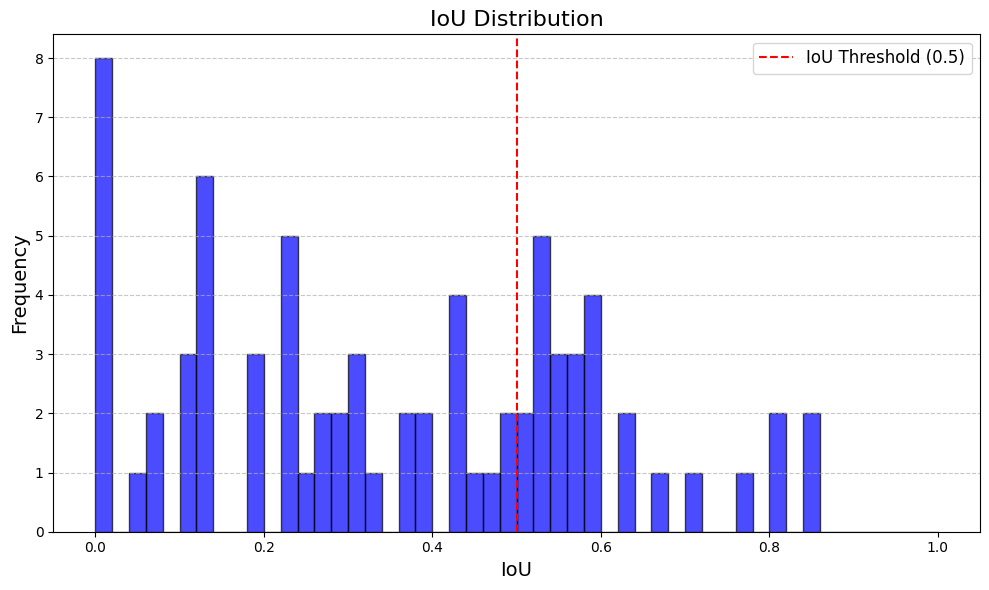

In [ ]:
# Plot IoU distribution
print("\nPlotting IoU distribution...")
plot_iou_distribution(test_metrics['all_ious'])